Hidden Shift Benchmark Program - Braket
... execution starting at Sep 18, 2024 12:04:56 UTC
************
Executing [3] circuits with num_qubits = 2
Average Circuit Algorithmic Depth, ξ (xi) for the 2 qubit group = 7, 0
Average Normalized Transpiled Depth, ξ (xi), 2q gates for the 2 qubit group = 7, 0, 0
Average Creation, Elapsed, Execution Time for the 2 qubit group = 0.002, 0.035, 0.035 secs
Average Hellinger, Normalized Fidelity for the 2 qubit group = 1.0, 1.0

************
Executing [3] circuits with num_qubits = 4
Average Circuit Algorithmic Depth, ξ (xi) for the 4 qubit group = 7, 0
Average Normalized Transpiled Depth, ξ (xi), 2q gates for the 4 qubit group = 7, 0, 0
Average Creation, Elapsed, Execution Time for the 4 qubit group = 0.001, 0.011, 0.011 secs
Average Hellinger, Normalized Fidelity for the 4 qubit group = 1.0, 1.0

************
Executing [3] circuits with num_qubits = 6
Average Circuit Algorithmic Depth, ξ (xi) for the 6 qubit group = 7, 0
Average Normalized Transpil

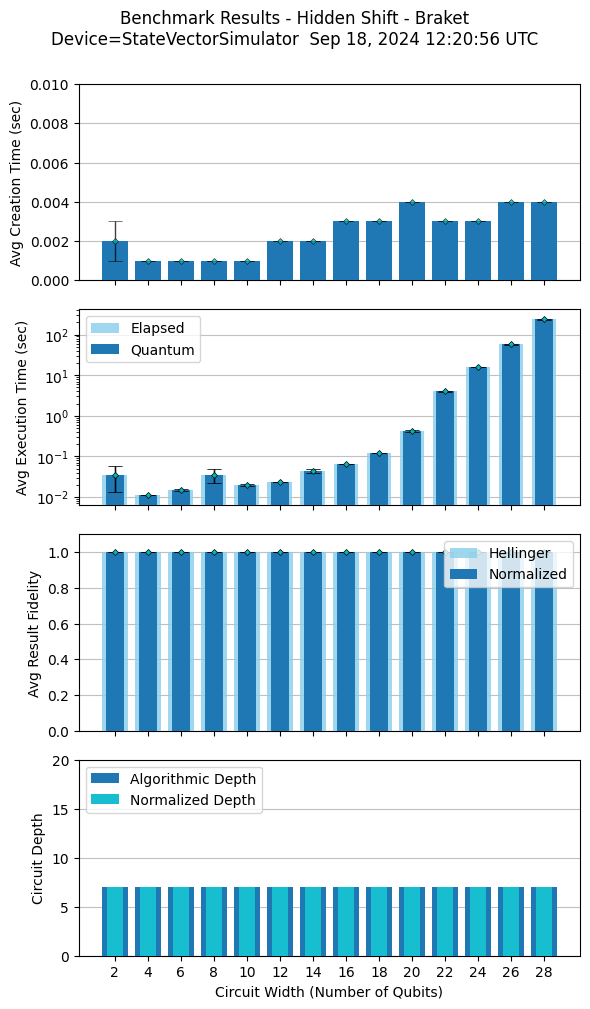

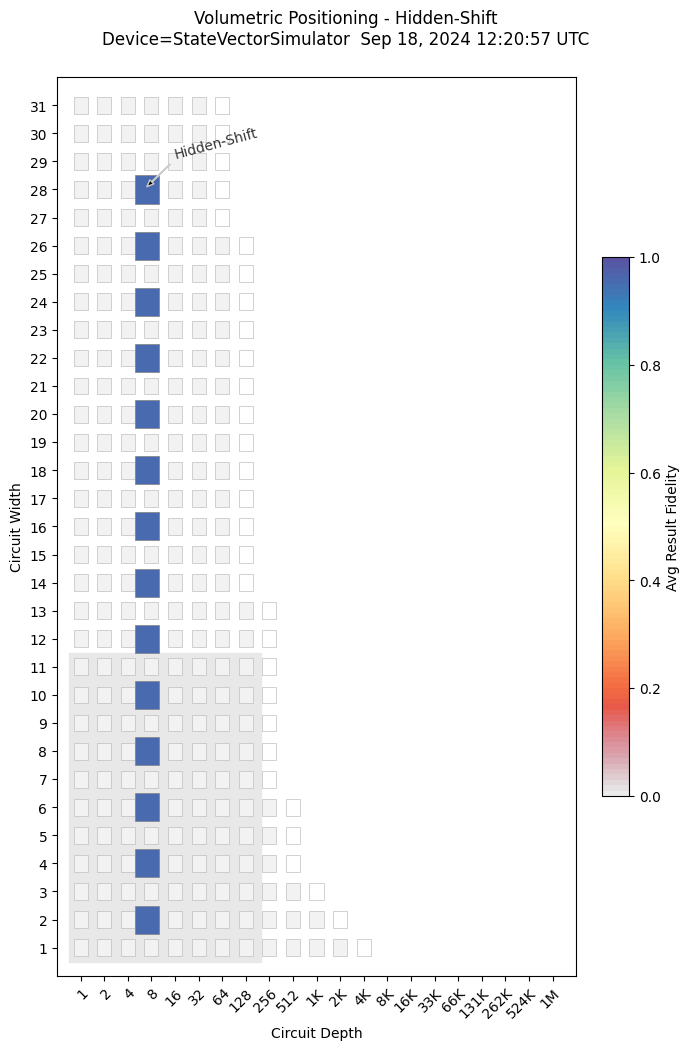

In [1]:
"""
Hidden Shift Benchmark Program - Braket
"""

import sys
import time

from braket.circuits import Circuit     # AWS imports: Import Braket SDK modules
import numpy as np

sys.path[1:1] = [ "_common", "_common/braket" ]
sys.path[1:1] = [ "../../_common", "../../_common/braket" ]
import execute as ex
import metrics as metrics

np.random.seed(0)

verbose = False

# saved circuits for display
QC_ = None
Uf_ = None
Ug_ = None

############### Circuit Definition
def Uf_oracle(num_qubits, secret_int):
    # allocate qubits
    qc = Circuit()

    # Perform X on each qubit that matches a bit in secret string
    s = ('{0:0' + str(num_qubits) + 'b}').format(secret_int)
    for i_qubit in range(num_qubits):
        if s[num_qubits - 1 - i_qubit] == '1':
            qc.x(i_qubit)

    for i_qubit in range(0, num_qubits - 1, 2):
        qc.cz(i_qubit, i_qubit + 1)

    # Perform X on each qubit that matches a bit in secret string
    s = ('{0:0' + str(num_qubits) + 'b}').format(secret_int)
    for i_qubit in range(num_qubits):
        if s[num_qubits - 1 - i_qubit] == '1':
            qc.x(i_qubit)

    #qc = cirq_utils.to_gate(num_qubits=num_qubits, circ=qc, name="Uf")

    return qc

def Ug_oracle(num_qubits):
    # allocate qubits
    qc = Circuit()

    for i_qubit in range(0,num_qubits-1,2):
        qc.cz(i_qubit, i_qubit+1)

    #qc = cirq_utils.to_gate(num_qubits=num_qubits, circ=qc, name="Ug")

    return qc

def HiddenShift (num_qubits, secret_int):
    
    # allocate qubits
    qc = Circuit()
    
    # Start with Hadamard on all input qubits
    for i_qubit in range(num_qubits):
         qc.h(i_qubit)

    Uf = Uf_oracle(num_qubits, secret_int)
    qc.add(Uf)

    # Again do Hadamard on all qubits
    for i_qubit in range(num_qubits):
         qc.h(i_qubit)

    Ug = Ug_oracle(num_qubits)
    qc.add(Ug)

    # End with Hadamard on all qubits
    for i_qubit in range(num_qubits):
         qc.h(i_qubit)

    # save smaller circuit example for display
    global QC_, Uf_, Ug_
    if QC_ == None or num_qubits <= 6:
        if num_qubits < 9: QC_ = qc
    if Uf_ == None or num_qubits <= 6:
        if num_qubits < 9: Uf_ = Uf
    if Ug_ == None or num_qubits <= 6:
        if num_qubits < 9: Ug_ = Ug

    # return a handle on the circuit
    return qc

############### Circuit end

# Analyze and print measured results
# Expected result is always the secret_int, so fidelity calc is simple
def analyze_and_print_result (qc, result, num_qubits, secret_int):

    # obtain shots from the result metadata
    num_shots = result.task_metadata.shots

    # obtain counts from the result object
    # for braket, need to reverse the key to match binary order
    # for braket, measures all qubits, so we have to remove data qubit measurement
    counts_r = result.measurement_counts
    counts = {}
    for measurement_r in counts_r.keys():
        measurement = measurement_r[::-1] # reverse order
        counts[measurement] = counts_r[measurement_r]  
    if verbose: print(f"For secret int {secret_int} measured: {counts}")
    
    # create the key that is expected to have all the measurements (for this circuit)
    key = format(secret_int, f"0{num_qubits}b")
    
    # correct distribution is measuring the key 100% of the time
    correct_dist = {key: 1.0}

    # use our polarization fidelity rescaling
    fidelity = metrics.polarization_fidelity(counts, correct_dist)

    return counts, fidelity

################ Benchmark Loop

# Execute program with default parameters
def run (min_qubits=2, max_qubits=28, max_circuits=3, num_shots=1000,
        backend_id='simulator'):

    print("Hidden Shift Benchmark Program - Braket")

    # validate parameters (smallest circuit is 2 qubits)
    max_qubits = max(2, max_qubits)
    min_qubits = min(max(2, min_qubits), max_qubits)
    if min_qubits % 2 == 1: min_qubits += 1   # min_qubits must be even
    #print(f"min, max qubits = {min_qubits} {max_qubits}")
    
    # Initialize metrics module
    metrics.init_metrics()

    # Define custom result handler
    def execution_handler (qc, result, num_qubits, s_int):  
     
        # determine fidelity of result set
        num_qubits = int(num_qubits)
        counts, fidelity = analyze_and_print_result(qc, result, num_qubits, int(s_int))
        metrics.store_metric(num_qubits, s_int, 'fidelity', fidelity)

    # Initialize execution module using the execution result handler above and specified backend_id
    ex.init_execution(execution_handler)
    ex.set_execution_target(backend_id)

    # Execute Benchmark Program N times for multiple circuit sizes
    # Accumulate metrics asynchronously as circuits complete
    for num_qubits in range(min_qubits, max_qubits + 1, 2):

        # determine number of circuits to execute for this group
        num_circuits = min(2 ** (num_qubits), max_circuits)
        
        print(f"************\nExecuting [{num_circuits}] circuits with num_qubits = {num_qubits}")
        
        # determine range of secret strings to loop over
        if 2**(num_qubits) <= max_circuits:
            s_range = list(range(num_circuits))
        else:
            s_range = np.random.choice(2**(num_qubits), num_circuits, False)
        
        # loop over limited # of secret strings for this
        for s_int in s_range:
        
            # create the circuit for given qubit size and secret string, store time metric
            ts = time.time()
            qc = HiddenShift(num_qubits, s_int)
            metrics.store_metric(num_qubits, s_int, 'create_time', time.time()-ts)
            
            # submit circuit for execution on target (simulator, cloud simulator, or hardware)
            ex.submit_circuit(qc, num_qubits, s_int, shots=num_shots)
        
        # execute all circuits for this group, aggregate and report metrics when complete
        ex.execute_circuits()
        metrics.aggregate_metrics_for_group(num_qubits)
        metrics.report_metrics_for_group(num_qubits)

    # Alternatively, execute all circuits, aggregate and report metrics
    #ex.execute_circuits()
    #metrics.aggregate_metrics_for_group(num_qubits)
    #metrics.report_metrics_for_group(num_qubits)

    # print a sample circuit
    print("Sample Circuit:"); print(QC_ if QC_ != None else "  ... too large!")
    print("\nQuantum Oracle 'Uf' ="); print(Uf_ if Uf_ != None else "  ... too large!")
    print("\nQuantum Oracle 'Ug' ="); print(Ug_ if Ug_ != None else "  ... too large!")

    # Plot metrics for all circuit sizes
    metrics.plot_metrics("Benchmark Results - Hidden Shift - Braket")

# if main, execute method
if __name__ == '__main__': run()
